In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [74]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [75]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [76]:
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [77]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Label: [    3     2     0     4     9     5     1     2     4     8]
Class:    cat  bird plane  deer truck   dog   car  bird  deer  ship


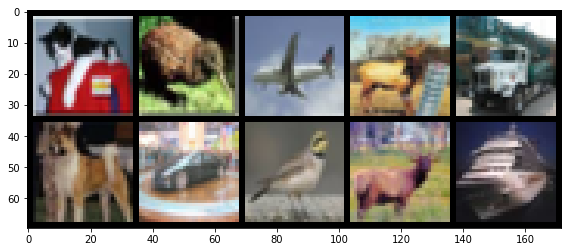

In [78]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [79]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [80]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [81]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [82]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.67172015  accuracy:  27.080%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.91580963  accuracy:  33.130%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.89692688  accuracy:  36.797%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.40766621  accuracy:  39.123%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.40583444  accuracy:  41.118%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.28380609  accuracy:  51.260%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.35742259  accuracy:  51.795%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.20425415  accuracy:  52.280%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.14655077  accuracy:  52.653%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 2.19020438  accuracy:  53.048%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.26571691  accuracy:  56.840%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.47672486  accuracy:  57.150%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 0.95467967  accuracy:  57.257%
epoch:  2  b

In [83]:
torch.save(model.state_dict(),'mycifarmodel.pt')

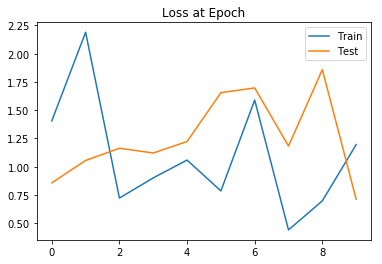

In [84]:
plt.plot(train_losses,label='Train')
plt.plot(test_losses,label='Test')
plt.legend()
plt.title('Loss at Epoch');

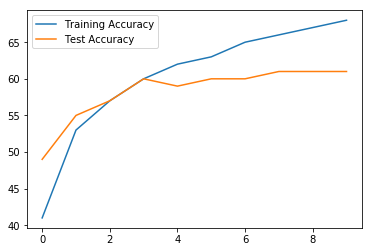

In [87]:
test_acc = [t/100 for t in test_correct]
train_acc = [t/500 for t in train_correct]
plt.plot(train_acc,label='Training Accuracy')
plt.plot(test_acc,label='Test Accuracy')
plt.legend();

In [88]:
print(test_correct)

[tensor(4920), tensor(5531), tensor(5765), tensor(6000), tensor(5994), tensor(6067), tensor(6016), tensor(6139), tensor(6135), tensor(6123)]


In [91]:
test_correct[-1].item()/100

61.23

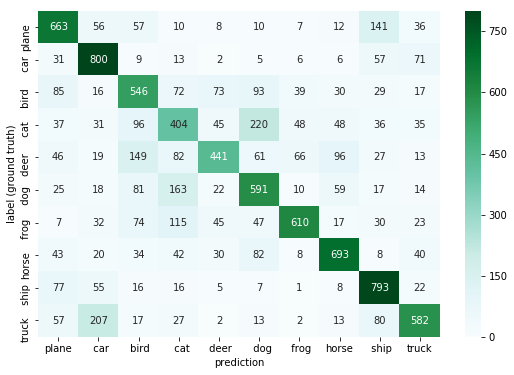

In [92]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();